# <center> CommonLit Readability Prize
![](https://storage.googleapis.com/kaggle-competitions/kaggle/25914/logos/header.png?t=2021-04-01-15-58-06)

# 0.Import Librairies :

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px 
import warnings
warnings.filterwarnings("ignore")
import nltk
import string
import seaborn as sns 
from collections import Counter
import operator
from math import ceil
import re
from transformers import BertTokenizer,BertModel
import torch 
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,LSTM,Dense,Bidirectional,\
Dropout,BatchNormalization,Input,Conv1D,MaxPool1D,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mse
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
import tensorflow as tf
import pickle
import shutil 
import random 
import os 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
import math

In [2]:
SEED = 42

def random_seed(SEED):
    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

# 1.Import Datas:

In [3]:
# Load the train datas
data = pd.read_csv("../input/commonlitreadabilityprize/train.csv")

In [4]:
# Let's take a look on the training datas :
data.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [5]:
# Let's take a look on test datas.
test = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
test.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


# 2.Explorations Datas Analysis (EDA):

### <font color=#FF15A8> Meta Features :

In [6]:
# words_count.

data["words_count"] = data["excerpt"].map(lambda x : len(x.split()))

# unique_words_count

data["unique_words_count"] = data["excerpt"].map(lambda x : len(set(str(x).lower().split())))

# stop_words_count 

data["stop_words_count"] = data["excerpt"].map(lambda x : len([elt for elt in str(x).lower().split() if\
                                                              elt in nltk.corpus.stopwords.words("english")]))
# characters_count 

data["characters_count"] = data["excerpt"].map(lambda x : len(str(x)))

#mean_words_length

data["mean_words_length"] = data["excerpt"].map(lambda x : np.mean([len(elt) for elt in \
                                                                    x.split()]))

#punctuation_count 

data["punctuation_count"] = data["excerpt"].map(lambda x : len([elt for elt in str(x).split()\
                                                               if elt in string.punctuation]))


In [7]:
# transform the target values to categorical variable,which represent the rate complexity 
# of reading passages for Quantile1 - Quantile4
data["target_bins"] = pd.cut(data["target"].values,[data["target"].min()-1,data["target"].quantile(0.25),\
                                                    data["target"].quantile(0.5),data["target"].quantile(0.75),data["target"].quantile(1)],right=True,labels=[f"Q{i}" for i in range(1,5)])

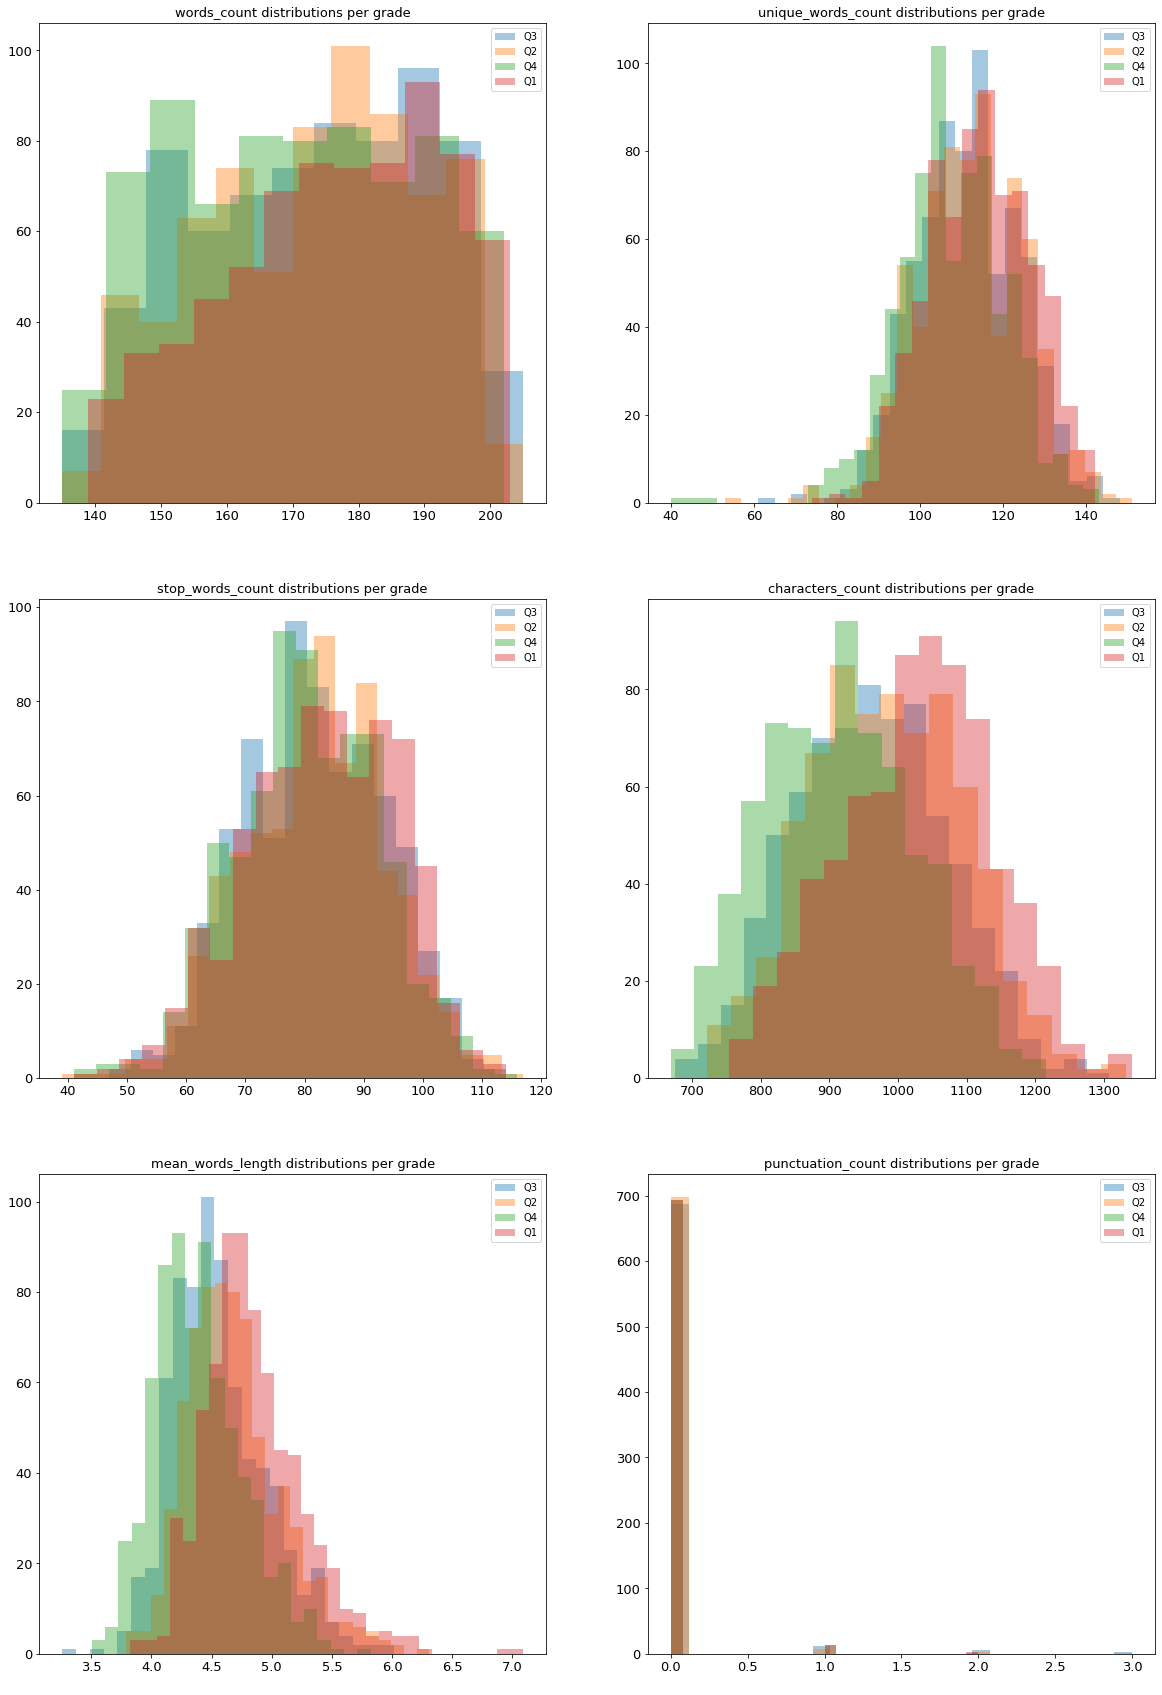

In [8]:
meta_features = ["words_count","unique_words_count","stop_words_count","characters_count",\
                "mean_words_length","punctuation_count"]
target_bins = data["target_bins"].unique()
fig, ax = plt.subplots(3,2,figsize=(20,30))
for i,meta in enumerate(meta_features) :
    for grade in target_bins :
        mask = data["target_bins"]== grade
        sns.distplot(data[mask][meta],ax=ax[i//2,i%2],label=grade,kde=False)
        ax[i//2,i%2].set_title(f"{meta} distributions per grade",fontsize=13)
        ax[i//2,i%2].set_xlabel(" ")
        ax[i//2,i%2].tick_params(axis="x",labelsize=13)
        ax[i//2,i%2].tick_params(axis="y",labelsize=13)
        ax[i//2,i%2].legend()
plt.show()

==> The meta features distributions per grade complexity of excerpt , show the following statements :

- Routhly same  distribution of words_count,unique_words_count,stop_words_count and punctuation_count per grade : This can allow us to conclude that theses features don't have informations about the target.
- characters_count and mean_words_length features , have apparently a differents distribution per grade, which confirm that theses features could bring informations about our target.  

We will hereunder investigate theses results by dressing the correlation of theses features with the target feature.


Text(0.5, 1.0, 'Correlation of Meta features with target')

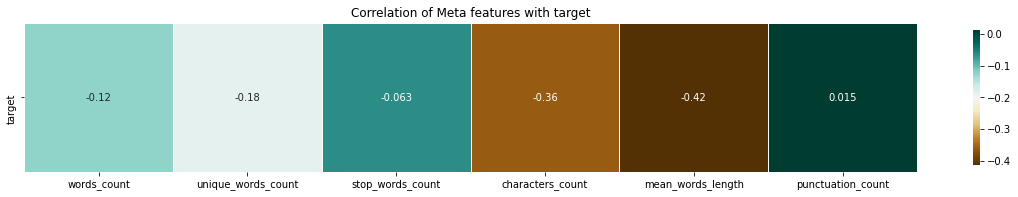

In [9]:
# Investigate correlation between meta features and the target fature.
fig = plt.figure(figsize=(20,5))
correlation = pd.DataFrame({feature: data["target"].corr(data[feature]) for feature in \
                           meta_features},index=["target"])
sns.heatmap(correlation,annot=True,square=True,cmap='BrBG',linewidths=0.5,\
            cbar_kws={"shrink": .5})
plt.title("Correlation of Meta features with target")

==> The table above , confirm the previous results which conclude that characters_count and mean_words_length could bring a valuable informations about our target. 

### <font color=#FF15A8> Embedding and Text Cleaning :

We will do text cleaning based in the gloves embedding technic.

In [10]:
# Distribution of each words in our corpus.
corpus = []
for tx in data["excerpt"].values :
    corpus.extend(str(tx).lower().split())
counter = Counter(corpus)
counter = dict(counter)

In [11]:
def check_embedding_coverage(embedding,counter):
    """This function allow to inspect the coverage of our corpus by the embedding word,
       represented in GloVe technic. 
       
       @param embedding(dict) : a dict of the words with their embedding coefficients in the used 
                                embedding technic.
       @param counter(dict) : a dict of the words distributions in the corpus that we would 
                              examinate.
       
       @return coverage_text (int): the coverage of our corpus by the terms used in the 
                                    introduced embedding technic.
       @return coverage_vocab(int) : the coverage of the vocab used in the corpus by the terms used
                                in the introduced embedding technic.
       @return oov (list) : ordered list of words,that not represented in the embedding technic 
                            terms.
    """
    oov_words = {}
    covered_words = {}
    n_coov = 0
    n_oov = 0
    for word in counter :
        try :
            covered_words[word] = embedding[word]
            n_coov += counter[word]
        except :
            oov_words[word] = counter[word]
            n_oov += counter[word]
    coverage_text = (n_coov/(n_coov+n_oov)) * 100 
    coverage_vocab = (len(covered_words)/len(counter)) *100
    oov = sorted(oov_words.items(),key=operator.itemgetter(1),reverse=True)
    
    return coverage_text,coverage_vocab,oov

In [12]:
# load Glove embedding terms and weights.
glove_embedding_file =  "../input/gloves-embedding-weights/glove.6B.300d.txt"
glove_embedding = {}
f = open(glove_embedding_file)
for l in f :
    content = l.split()
    glove_embedding[content[0]] = np.asarray(content[1:])

In [13]:
coverage_text,coverage_vocab,oov = check_embedding_coverage(glove_embedding,counter)
print(f"Glove embedding cover {ceil(coverage_vocab)} % of vocabulary and {ceil(coverage_text)} % of text in our training corpus")

Glove embedding cover 43 % of vocabulary and 86 % of text in our training corpus


In [14]:
test_corpus = []
for tx in test["excerpt"].values :
    test_corpus.extend(tx.lower().split())
test_counter = Counter(test_corpus)

In [15]:
coverage_text,coverage_vocab,oov = check_embedding_coverage(glove_embedding,test_counter)
print(f"Glove embedding cover {ceil(coverage_vocab)} % of vocabulary and {ceil(coverage_text)} % of text in our test corpus")

Glove embedding cover 76 % of vocabulary and 86 % of text in our test corpus


We will made the following cleaning in order to enhance coverage embedding of text and vocab :
- The most common type of words that require cleaning , have punctuations at first or in the end of the word.THe words don't have embedding because the trailing punctuations. Punctuations : . , ? ! ; " (
- Typos and slang are corrected , and informal abbreviation are written in their long form.

In [16]:
def clean_text(excerpt):
    punctuations = ".,?!;\(\":-)‘"
    extrait = excerpt
    for p in punctuations : 
      extrait = extrait.replace(p,f" {p} ")
    extrait = re.sub(r"'s"," is ",extrait)
    extrait = extrait.replace("i'm","I'm")
    extrait = extrait.replace("don't","do not")
    extrait = extrait.replace("didn't","did not")
    extrait = extrait.replace("can't","cannot")
    extrait = extrait.replace("i'll","I will")
    extrait = extrait.replace("wouldn't","would not")
    extrait = extrait.replace("i've","I have")
    extrait = re.sub(r"i've","I have",extrait)
    extrait = extrait.replace("won't","will not")
    extrait = extrait.replace("couldn't","could not")
    extrait = extrait.replace("wasn't","was not")
    extrait = extrait.replace("you'll","you will")
    extrait = extrait.replace("isn't","is not")
    extrait = extrait.replace("you're","you are")
    extrait = extrait.replace("hadn't","had not")
    extrait = extrait.replace("you've","you have")
    extrait = extrait.replace("doesn't","does not")
    extrait = extrait.replace("haven't","have not")
    extrait = extrait.replace("they're","they are")
    extrait = extrait.replace("we're","we are")
    #extrait = re.sub(r"(/s+)i(/s+)","I",excerpt)
    #extrait = re.sub(r"don't","do not",extrait)
    #extrait = re.sub(r"i'm","I'm",extrait)
    #extrait = re.sub(r"man's","man is",extrait)
    #extrait = re.sub(r"it's","it is",extrait)
    #extrait = re.sub(r"didn't","did not",extrait)
    #extrait = re.sub(r"can't","cannot",extrait)
    #extrait = re.sub(r"earth's","earth is",extrait)
    #extrait = re.sub(r"father's","father is",extrait)
    #extrait = re.sub(r"i'll","I will",extrait)
    #extrait = re.sub(r"i've","I have",extrait)
    #extrait = re.sub(r"i\'",r"I'",extrait)
    #extrait = re.sub(r"children\'s","children is",extrait)
    
    return extrait 

In [17]:
# clean the train datas
data["cleaned_excerpt"] = data["excerpt"].map(clean_text)

In [18]:
corpus = []
for tx in data["cleaned_excerpt"].values :
    corpus.extend(str(tx).lower().split())
counter = Counter(corpus)
coverage_text,coverage_vocab,oov = check_embedding_coverage(glove_embedding,counter)
print(f"Glove embedding cover {ceil(coverage_vocab)} % of vocabulary and {ceil(coverage_text)} % of text in our cleaned training corpus")

Glove embedding cover 91 % of vocabulary and 100 % of text in our cleaned training corpus


In [19]:
# clean the test datas.
test["cleaned_excerpt"] = test["excerpt"].map(clean_text)

In [20]:
test_corpus = []
for tx in test["cleaned_excerpt"].values :
    test_corpus.extend(str(tx).lower().split())
counter = Counter(test_corpus)
coverage_text,coverage_vocab,oov = check_embedding_coverage(glove_embedding,counter)
print(f"Glove embedding cover {ceil(coverage_vocab)} % of vocabulary and {ceil(coverage_text)} % of text in our cleaned training corpus")

Glove embedding cover 100 % of vocabulary and 100 % of text in our cleaned training corpus


# 3. Modeling:

### <font color=#FF15A8> LSTM +CNN :

#### <b> Data preparation  </b>:

In [21]:
# split datas to train and test datas.
data_tr,data_ts,ytr,yts = train_test_split(data,data["target"],test_size=\
                                  0.2,stratify=data["target_bins"].values,random_state=42)

In [22]:
lstm_tokenizer = Tokenizer(27892,oov_token="<OOV>")
lstm_tokenizer.fit_on_texts(data["cleaned_excerpt"].values)
word_index = lstm_tokenizer.word_index

In [23]:
def preprocessing_data(txs,tokenizer,max_len):
    x = tokenizer.texts_to_sequences(txs)
    x = pad_sequences(x,maxlen=max_len,padding="post",truncating="post")
    return x

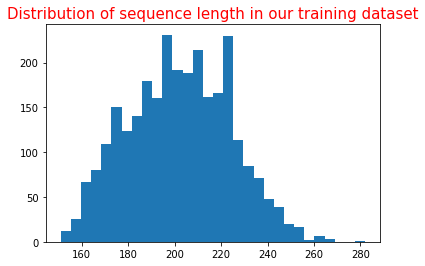

In [24]:
# plot the sequence length distribution.
lengths = [len(seq.split()) for seq in data["cleaned_excerpt"].values]
plt.hist(lengths,bins=30)
plt.title("Distribution of sequence length in our training dataset",size=15,color="red")
plt.show()

In [25]:
input_length = 280 

#### <b> LSTM Model  </b>:

In [26]:
embedding_matrix = np.zeros((len(word_index)+1,300))
for word,i in lstm_tokenizer.word_index.items() :
    if glove_embedding.get(word) is not None:
        embedding_matrix[i,:] = glove_embedding.get(word)
   

In [27]:
embedding_layer = Embedding(len(word_index)+1,300,weights=[embedding_matrix],input_length=\
                           input_length,trainable=False)

In [28]:
def lstm_model() :
    model = Sequential([embedding_layer,Bidirectional(LSTM(64,return_sequences=True)),\
                   Bidirectional(LSTM(32,return_sequences=True)),Dense(1)])
    model.compile(loss="mse",optimizer="adam",metrics="mse")
    return model 

In [29]:
checkpoint_lstm = './lstm/checkpoint'
early_stopping = EarlyStopping(patience=20,min_delta=0.1,monitor="val_loss")
check_point = ModelCheckpoint(checkpoint_lstm,monitor="val_loss",save_weights_only=True,\
                             save_best_only=True,mode="min")

Epoch 1/100
57/57 [==============================] - 11s 84ms/step - loss: 1.2333 - mse: 1.2333 - val_loss: 0.7724 - val_mse: 0.7724
Epoch 2/100
57/57 [==============================] - 3s 51ms/step - loss: 0.7797 - mse: 0.7797 - val_loss: 0.6274 - val_mse: 0.6274
Epoch 3/100
57/57 [==============================] - 3s 51ms/step - loss: 0.6935 - mse: 0.6935 - val_loss: 0.8172 - val_mse: 0.8172
Epoch 4/100
57/57 [==============================] - 3s 51ms/step - loss: 0.7248 - mse: 0.7248 - val_loss: 0.7408 - val_mse: 0.7408
Epoch 5/100
57/57 [==============================] - 3s 52ms/step - loss: 0.6857 - mse: 0.6857 - val_loss: 0.6195 - val_mse: 0.6195
Epoch 6/100
57/57 [==============================] - 3s 51ms/step - loss: 0.8215 - mse: 0.8215 - val_loss: 0.7451 - val_mse: 0.7451
Epoch 7/100
57/57 [==============================] - 3s 51ms/step - loss: 0.6689 - mse: 0.6689 - val_loss: 0.6770 - val_mse: 0.6770
Epoch 8/100
57/57 [==============================] - 3s 53ms/step - loss: 0

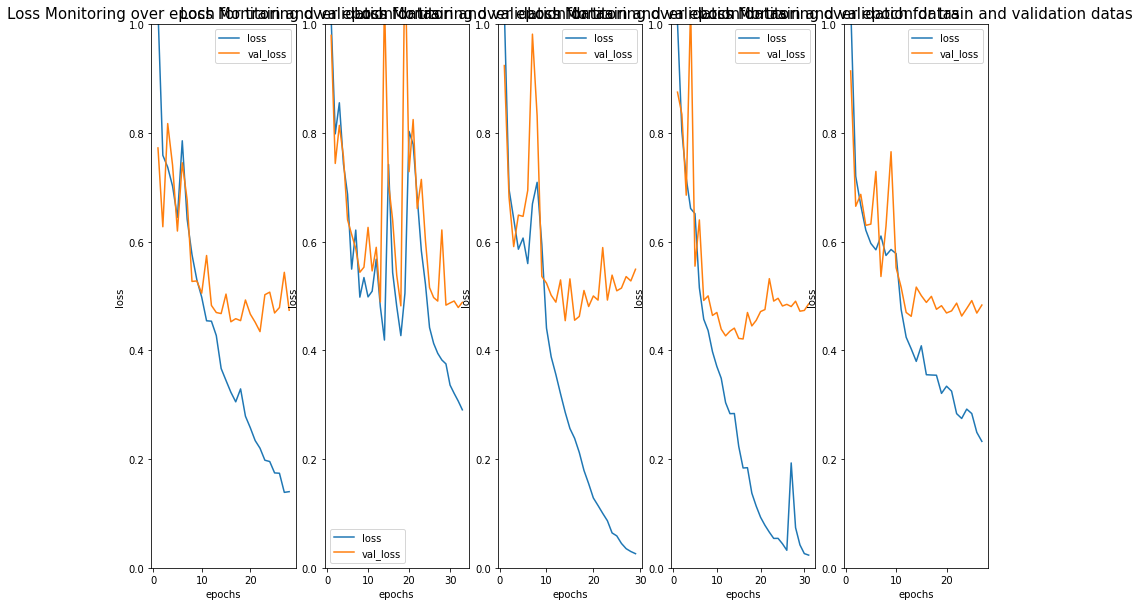

In [30]:
st = StratifiedKFold(n_splits=5)
lstm_models = []
fig,ax = plt.subplots(1,5,figsize=(15,10))
for i,(tr_index,val_index) in enumerate(st.split(data_tr,data_tr["target_bins"])):
    tr_x,val_x = data_tr.reset_index(drop=True).loc[tr_index,"cleaned_excerpt"].values, data_tr.reset_index(drop=True).loc[val_index,"cleaned_excerpt"].values
    tr_y,val_y = data_tr.reset_index(drop=True).loc[tr_index,"target"].values,data_tr.reset_index(drop=True).loc[val_index,"target"].values
    tr_x = preprocessing_data(tr_x,lstm_tokenizer,input_length)
    val_x = preprocessing_data(val_x,lstm_tokenizer,input_length)
    model = lstm_model()
    his = model.fit(tr_x,tr_y,validation_data=(val_x,val_y),batch_size=32,callbacks=[check_point,\
                                                                                    early_stopping],epochs=100)
    model.load_weights(checkpoint_lstm)
    lstm_models.append(model)
    ax[i].plot(np.arange(1,len(his.history["loss"])+1),his.history["loss"],label="loss")
    ax[i].plot(np.arange(1,len(his.history["loss"])+1),his.history["val_loss"],label="val_loss")
    ax[i].legend()
    ax[i].set_ylim([0,1])
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel("loss")
    ax[i].set_title("Loss Monitoring over epoch for train and validation datas",size=15)

In [31]:
xts_seq = preprocessing_data(data_ts["cleaned_excerpt"].values,lstm_tokenizer,input_length)
Yts = np.mean(np.concatenate([np.mean(model.predict(xts_seq),axis=1) for model in lstm_models],axis=1),axis=1)
MSE = mean_squared_error(yts,Yts)
print(f"The RMSE error of the lstm model = {math.sqrt(MSE)}")

The RMSE error of the lstm model = 0.6513220576358414


In [32]:
# prepare first prediction 
X = test["cleaned_excerpt"].values
X = preprocessing_data(X,lstm_tokenizer,input_length)
prediction = np.mean(np.concatenate([np.mean(model.predict(X),axis=1) for model in lstm_models],axis=1),axis=1)

In [33]:
submission = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")
submission["target"] = prediction 
submission.to_csv("submission.csv",index=False)

#### <b> CNN Model  </b>:

In [34]:
# Build cnn model.
def build_cnn_model():
  inp = Input(shape=(input_length,))
  emb = embedding_layer(inp)
  conv1 = Conv1D(128,2,activation="relu")(emb)
  maxp1 = MaxPool1D(2)(conv1)
  conv2 = Conv1D(128,2,activation="relu")(maxp1)
  maxp2 = MaxPool1D(2)(conv2)
  conv3 = Conv1D(128,2,activation="relu")(maxp2)
  maxp3 = MaxPool1D(2)(conv3)
  #conv4 = Conv1D(16,2,activation="relu")(maxp3)
  #maxp4 = MaxPool1D(2)(conv4)
  fl = Flatten()(maxp3)
  drop = Dropout(0.2)(fl)
  batch = BatchNormalization()(drop)
  out = Dense(60)(batch)
  drop = Dropout(0.2)(out)
  batch = BatchNormalization()(drop)
  out = Dense(30)(batch)
  drop = Dropout(0.2)(out)
  batch = BatchNormalization()(drop)
  out = Dense(1)(batch)
  cnn_model = tf.keras.models.Model(inputs=[inp],outputs=[out])
  cnn_model.compile(loss="mse",optimizer="adam",metrics="mse")
  return cnn_model

In [35]:
checkpoint_cnn = './cnn/checkpoint'
check_point = ModelCheckpoint(checkpoint_cnn,monitor="val_loss",save_weights_only=True,\
                             save_best_only=True,mode="min")

Epoch 1/100
19/19 [==============================] - 5s 73ms/step - loss: 3.1656 - mse: 3.1656 - val_loss: 1.1025 - val_mse: 1.1025
Epoch 2/100
19/19 [==============================] - 0s 22ms/step - loss: 1.6526 - mse: 1.6526 - val_loss: 1.1118 - val_mse: 1.1118
Epoch 3/100
19/19 [==============================] - 0s 23ms/step - loss: 1.2299 - mse: 1.2299 - val_loss: 0.9842 - val_mse: 0.9842
Epoch 4/100
19/19 [==============================] - 0s 22ms/step - loss: 1.0383 - mse: 1.0383 - val_loss: 0.7097 - val_mse: 0.7097
Epoch 5/100
19/19 [==============================] - 0s 22ms/step - loss: 0.9726 - mse: 0.9726 - val_loss: 0.6165 - val_mse: 0.6165
Epoch 6/100
19/19 [==============================] - 0s 22ms/step - loss: 0.7933 - mse: 0.7933 - val_loss: 0.6669 - val_mse: 0.6669
Epoch 7/100
19/19 [==============================] - 0s 22ms/step - loss: 0.6990 - mse: 0.6990 - val_loss: 0.5761 - val_mse: 0.5761
Epoch 8/100
19/19 [==============================] - 0s 22ms/step - loss: 0.

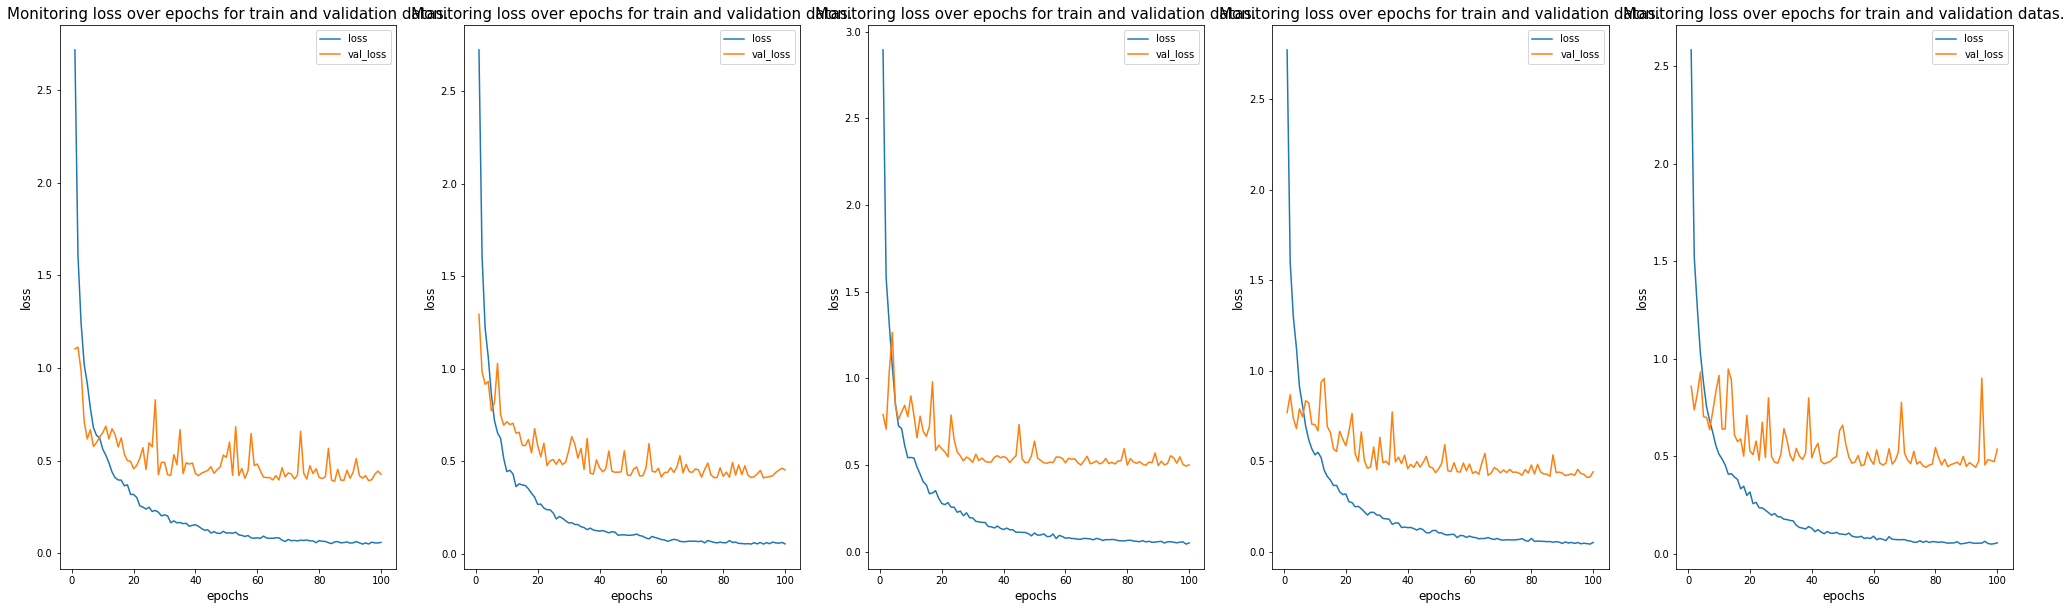

In [36]:
cnn_models = []
fig,ax = plt.subplots(1,5,figsize=(35,10))
for i ,(tr_index,val_index) in enumerate(st.split(data_tr,data_tr["target_bins"])) :
    x_tr,x_val = data_tr.reset_index(drop=True).loc[tr_index,"cleaned_excerpt"].values,data_tr.reset_index(drop=True).loc[val_index,"cleaned_excerpt"].values
    y_tr,y_val = data_tr.reset_index(drop=True).loc[tr_index,"target"].values,data_tr.reset_index(drop=True).loc[val_index,"target"].values
    
    x_tr = preprocessing_data(x_tr,lstm_tokenizer,input_length)
    x_val =preprocessing_data(x_val,lstm_tokenizer,input_length)
    md = build_cnn_model()
    cnn_hist = md.fit(x_tr,y_tr,validation_data=(x_val,y_val),epochs=100,batch_size=100,\
                     callbacks=[check_point])
    md.load_weights(checkpoint_cnn)
    cnn_models.append(md)
    ax[i].plot(np.arange(1,101),cnn_hist.history["loss"],label="loss")
    ax[i].plot(np.arange(1,101),cnn_hist.history["val_loss"],label="val_loss")
    ax[i].legend()
    ax[i].set_xlabel("epochs",size=12)
    ax[i].set_ylabel("loss",size=12)
    ax[i].set_title("Monitoring loss over epochs for train and validation datas.",size=15)
plt.show()

In [37]:
# Evaluate cnn models in test datas 
Y_cnn = np.mean(np.concatenate([cnn_model.predict(xts_seq) for cnn_model in cnn_models],axis=1),axis=1)
Cnn_MSE = mean_squared_error(yts,Y_cnn)
print(f"The RMSE error for CNN model = {math.sqrt(Cnn_MSE)}")

The RMSE error for CNN model = 0.6758452364026268


In [38]:
# Prepare CNN submission.
cnn_prediction = np.mean(np.concatenate([cnn_model.predict(X) for cnn_model in cnn_models],axis=1),axis=1)
cnn_submission = submission
cnn_submission["target"] = cnn_prediction
#cnn_submission.to_csv("submission.csv",index=False)

#### <b> Blended CNN and LSTM model  </b>:

In [39]:
coeff = []
for i in range(1,11):
    coeff.append(i * 0.1)

In [40]:
result_blended = []
best_coef_cnn = 0
best_rest = float("inf")
for i in range(10) :
    lstm_prediction = np.mean(np.concatenate([np.mean(model.predict(xts_seq),axis=1) for model in lstm_models],axis=1),axis=1)
    prediction_cnn = np.mean(np.concatenate([cnn_model.predict(xts_seq) for cnn_model in cnn_models],axis=1),axis=1)
    pred = coeff[i] * prediction_cnn + (1-coeff[i]) * lstm_prediction
    #res = coeff[i] * cnn_model.evaluate(xts_seq,yts)[0] + (1-coeff[i]) * (mean_squared_error(np.mean(model.predict(xts_seq),axis=1),yts))
    res = math.sqrt(mean_squared_error(yts,pred))
    result_blended.append(res)
    if res < best_rest :
        best_coef_cnn = coeff[i]
        best_rest = res

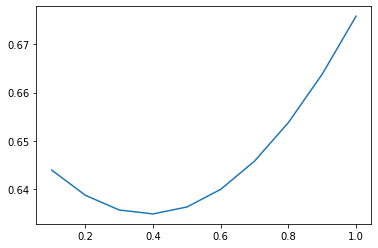

In [41]:
plt.plot(coeff,result_blended)

In [42]:
best_coef_cnn # best coefficient to adopt for cnn model 

0.4

In [43]:
best_rest # RMSE OF BLENDED MODEL 

0.6348122074219718

In [44]:
blended_pred = 0.6 * cnn_prediction + 0.4 * prediction

In [45]:
blended_submission = submission
blended_submission["target"] = cnn_prediction
blended_submission.to_csv("submission.csv",index=False)

#### <b> Bert model  </b>:

In [46]:
def preprocessing_for_bert(tokenizer,text,max_len):
    tokens_ids = []
    mask_attention = []
    for tx in text :
        tok = tokenizer.encode_plus(tx,add_special_tokens=True,padding="max_length",max_length=\
                              max_len,truncation=True)
        tokens_ids.append(tok.get("input_ids"))
        mask_attention.append(tok.get("attention_mask"))
    
    inp_ids = torch.tensor(tokens_ids)
    mask_attention = torch.tensor(mask_attention)
    
    return inp_ids,mask_attention

In [47]:
class BertRegressor(nn.Module):
    def __init__(self,bert_base,freeze_layer=True):
        super(BertRegressor,self).__init__()
        self.bert = bert_base
        self.dense = nn.Linear(768,120)
        self.dropout = nn.Dropout(p=0.3)
        self.batch_n = nn.BatchNorm1d(120)
        self.freeze = freeze_layer
        self.regressor = nn.Linear(120,1)
        
        if  freeze_layer :
            for param in self.bert.parameters():
                param.requires_grad = False
    def forward(self,input_ids,mask_attention):
        hidden_states = self.bert(input_ids,mask_attention)[0][:,0,:]
        out = self.dropout(hidden_states)
        out = self.dense(out)
        out = self.batch_n(out)
        out = self.dropout(out)
        out = self.regressor(out)
        return out 

In [48]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else :
    print("No GPU available, using CPU instead")
    device = torch.device("cpu")

In [49]:
with open("../input/bert-model-training/bert_layer","rb") as f :
    bert_base = pickle.load(f)

In [50]:
bregressor = BertRegressor(bert_base)
bregressor.load_state_dict(torch.load("../input/bert-model-training/bert_model"),strict = False)
bregressor.to(device)

BertRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [51]:
with open("../input/bert-model-training/tokenizer","rb") as f :
    tokenizer = pickle.load(f)

In [52]:
batch_size = 8 
test_id,test_mask = preprocessing_for_bert(tokenizer,test["cleaned_excerpt"].values,input_length)
test_dataset = TensorDataset(test_id,test_mask)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size)

In [53]:
bert_prediction = []
bregressor.eval()
for datas in test_dataloader :
    inp_id,mask_att = (t.to(device) for t in datas)
    with torch.no_grad() :
        output = bregressor(inp_id,mask_att)
        output = output.cpu().numpy()
    bert_prediction.extend([elt[0] for elt in output])

In [54]:
b_submission = submission
b_submission["target"] = bert_prediction
#b_submission.to_csv("submission.csv",index=False)

#### <b>  Combined Model </b>:

# Build Combined model 
# This model will try to include all features and structure , which can affect the target.

cnn_input = Input(shape=(input_length,))
emb = embedding_layer(cnn_input)
lstm_input = Bidirectional(LSTM(64,return_sequences=True))(emb)
lstm = Bidirectional(LSTM(32,return_sequences=True))(lstm_input)
conv_1 = Conv1D(120,2,activation="relu")(lstm)
pool_1 = MaxPool1D(2)(conv_1)
conv_2 = Conv1D(120,2,activation="relu")(pool_1)
pool_2 = MaxPool1D(2)(conv_2)
conv_3 = Conv1D(120,2,activation="relu")(pool_2)
pool_3 = MaxPool1D(2)(conv_3)
fl = Flatten()(pool_3)
#lstm_input = Bidirectional(LSTM(64,return_sequences=True))(emb)
#lstm = Bidirectional(LSTM(32,))(lstm_input)
#meta_features_inp = Input(shape=(2,))
#x = tf.keras.layers.concatenate([fl,lstm],axis=1)
drop = Dropout(0.2)(fl)
batch_n = BatchNormalization()(drop)
out = Dense(60)(batch_n)
drop = Dropout(0.2)(out)
batch_n = BatchNormalization()(drop)
out = Dense(30)(batch_n)
#meta_features_inp = Input(shape=(2,))
drop = Dropout(0.2)(out)
batch_n = BatchNormalization()(drop)
out = Dense(1)(batch_n)

#meta_features_inp = BatchNormalization()(meta_features_inp)
#x = tf.keras.layers.concatenate([out,meta_features_inp],axis=1)
#drop = Dropout(0.2)(out)
#batch_n = BatchNormalization()(drop)
#out = Dense(1)(batch_n)
comb_model = tf.keras.models.Model(inputs=[cnn_input],outputs=out)
comb_model.compile(loss="mse",optimizer = tf.keras.optimizers.Adam(lr=5e-5),\
            metrics="mse")

xtr,xts,ytr,yts = train_test_split(data.loc[:,["cleaned_excerpt","mean_words_length",\
                                         "characters_count"]],data["target"].values,test_size=0.2,random_state=42,\
                                   stratify=data["target_bins"].values)

def pre_processing_for_combined_model(x,tokenizer,max_len):
    x_text = x.iloc[:,0].values
    x_tex_seq = tokenizer.texts_to_sequences(x_text)
    x_tex_seq = pad_sequences(x_tex_seq,maxlen=max_len,padding="post",truncating="post")
    
    x_series = x.iloc[:,[1,2]].values
    
    return x_tex_seq , x_series

Xtr = pre_processing_for_combined_model(xtr,lstm_tokenizer,input_length)
Xts = pre_processing_for_combined_model(xts,lstm_tokenizer,input_length)

best_combined = "./best_combined.pth"
combined_check_point = ModelCheckpoint(best_combined,monitor="val_loss",mode="min",\
                                       save_weights_only=True,save_best_only=True)

comb_model.summary()

hist_comb = comb_model.fit(Xtr[0],ytr,validation_data=(Xts[0],yts),epochs=100,batch_size=32,\
                          callbacks=[combined_check_point])

plt.plot(np.arange(1,101),hist_comb.history["loss"],label="train_loss")
plt.plot(np.arange(1,101),hist_comb.history["val_mse"],label="val_loss")
plt.legend(loc="best")
plt.xlim([1,100])
plt.ylim([0,1])
plt.title("Loss monitoring over epochs")

## <font color=red> We will come back , upvote and leave your comments to enrich the work.